In [23]:
import sys
import numpy as np
import scipy.stats
from itertools import product
import cvxpy as cp
from collections import Counter, defaultdict
import json
import random

# Pull genotypes for a chromosome
data_dir = '../split_gen_ihart'
chroms = [str(i) for i in range(1, 23)] + ['X', 'Y']
ped_file = '../data/v34.vcf.ped'

# Basic info

In [2]:
chrom_lengths = {
	'1': 225934550,
	'2': 238204522,
	'3': 194797140,
	'4': 188042934,
	'5': 177695260,
	'6': 167395067,
	'7': 155536559,
	'8': 142964911,
	'9': 120626573,
	'10': 131314747,
	'11': 131169619,
	'12': 130481395,
	'13': 95589878,
	'14': 88289540,
	'15': 81694769,
	'16': 78884753,
	'17': 78129607,
	'18': 74661510,
	'19': 56060841,
	'20': 59505520,
	'21': 35134224,
	'22': 34894566,
	'X': 151100560,
	'Y': 25653566
}

In [42]:
gens = ['0/0', '0/1', '1/1', '-/0', '-/1', '-/-']
obs = ['0/0', '0/1', '1/1', './.']

gen_to_obs = dict([(0, 0), (1, 1), (2, 2), (3, 0), (4, 2), (5, 3)])
obs_to_gen = dict([(0, 0), (1, 1), (2, 2), (3, 5)])

In [5]:
mendelian_trios = {
    (0, 0, 0), 
    (0, 1, 0), (0, 1, 1),
    (0, 2, 1),
    (0, 3, 0), (0, 3, 3),
    (0, 4, 1), (0, 4, 3),
    (0, 5, 3),
    (1, 0, 0), (1, 0, 1),
    (1, 1, 0), (1, 1, 1), (1, 1, 2),
    (1, 2, 1), (1, 2, 2),
    (1, 3, 0), (1, 3, 1), (1, 3, 3), (1, 3, 4),
    (1, 4, 1), (1, 4, 2), (1, 4, 3), (1, 4, 4),
    (1, 5, 3), (1, 5, 4),
    (2, 0, 1),
    (2, 1, 1), (2, 1, 2),
    (2, 2, 2),
    (2, 3, 1), (2, 3, 4),
    (2, 4, 2), (2, 4, 4),
    (2, 5, 4),
    (3, 0, 0), (3, 0, 3),
    (3, 1, 0), (3, 1, 1), (3, 1, 3), (3, 1, 4),
    (3, 2, 1), (3, 2, 4),
    (3, 3, 0), (3, 3, 3), (3, 3, 5),
    (3, 4, 1), (3, 4, 3), (3, 4, 4), (3, 4, 5),
    (3, 5, 3), (3, 5, 5),
    (4, 0, 1), (4, 0, 3),
    (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4),
    (4, 2, 2), (4, 2, 4),
    (4, 3, 1), (4, 3, 3), (4, 3, 4), (4, 3, 5),
    (4, 4, 2), (4, 4, 4), (4, 4, 5),
    (4, 5, 4), (4, 5, 5),
    (5, 0, 3),
    (5, 1, 3), (5, 1, 4),
    (5, 2, 4),
    (5, 3, 3), (5, 3, 5),
    (5, 4, 4), (5, 4, 5),
    (5, 5, 5)
}

# pull data


In [7]:
sample_id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]

        sample_id_to_sex[m_id] = '2'
        sample_id_to_sex[f_id] = '1'
        if len(pieces) > 4:
            sample_id_to_sex[child_id] = pieces[4]
            
print('pulled sex for %d inds' % len(sample_id_to_sex))


pulled sex for 4858 inds


In [30]:
family_to_counts = defaultdict(list)
family_to_inds = dict()
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    with open('%s/chr.%s.famgen.counts.txt' % (data_dir, chrom), 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            famkey, inds = pieces[:2]
            
            if 'ssc' in data_dir:
                # unfortunately, ssc uses . in their sample names
                inds = inds.split('.')
                inds = ['%s.%s' % (inds[i], inds[i+1]) for i in range(0, len(inds), 2)]
            else:
                inds = inds.split('.')

            m = len(inds)

            if m<=7:
                if famkey not in family_to_inds:
                    family_to_inds[famkey] = inds
                else:
                    assert family_to_inds[famkey] == inds
                
                counts = np.zeros((len(obs),)*m, dtype=int)
                for g, c in zip(product(list(range(len(obs))), repeat=m), pieces[2:]):
                    counts[g] = int(c)
                    
                family_to_counts[famkey].append(counts)

print('Families of each size', Counter([len(inds) for fkey, inds in family_to_inds.items()]))
famkeys = sorted(set([x[0] for x in family_chrom_to_counts.keys()]))
famkeys = [k for k in famkeys if np.all([ind in sample_id_to_sex for ind in family_to_inds[k]])]
print('Families', len(famkeys))


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 X Y Families of each size Counter({4: 436, 5: 357, 6: 56, 3: 18, 7: 13})
Families 880


# Error graph

In [150]:
def create_error_graph(errors, famgens, famobss):
    error_to_pairs = defaultdict(list)       
    famobs_to_index = dict([(x, i) for i, x in enumerate(famobss)])
    
    for i, famgen in enumerate(famgens):
        famobs = [gen_to_obs[gen] for gen in famgen]
        for j in range(famsize):
            for o in range(len(obs)):
                new_famobs = tuple([o if k==j else famobs[k] for k in range(famsize)])
                if new_famobs in famobs_to_index:
                    error_to_pairs[(j, famgen[j], o)].append((i, famobs_to_index[new_famobs]))
    return error_to_pairs

# Poisson Regression

In [155]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

def estimate_error_rates(error_to_pairs, obs_counts, gen_counts, errors, famgens, famobss):
    error_to_index = dict([(x, i) for i, x in enumerate(errors)])
    
    # (famobs x errors) (errors) = (famobs)
    X = np.zeros((len(famobss), len(errors)))    
    for error, gen_obs_pairs in error_to_pairs.items():
        error_index = error_to_index[error]
        for gen_index, obs_index in gen_obs_pairs:
            X[obs_index, error_index] += gen_counts[gen_index]
                
    #status, error_rates, exp, obs, = poisson_regression(X, obs_counts)
    
    # cvxpy
    alpha = 1.0/np.max(X)
    n = cp.Variable(X.shape[1])
    mu = np.sum(alpha*X, axis=0)
    objective = cp.Minimize(mu*n - alpha*obs_counts*cp.log(alpha*X*n))
    
    constraints = [n>=0, n<=1]
    #for i in np.arange(0, len(errors), 4):
    #    constraints.append(cp.sum(n[(4*i):(4*(i+1))]) == 1)
    prob = cp.Problem(objective, constraints)
    
    result = prob.solve(solver='ECOS', max_iters=1000)
    print(prob.status)
    
    error_rates = np.asarray([v for v in n.value])
    
    plt.loglog(X.dot(error_rates), obs_counts, linewidth=0, marker='.')
    plt.show()
    
    print('updated error_rates, RMSE:', rmse(X.dot(error_rates), obs_counts))
    return error_rates
        

In [156]:
def estimate_gen_counts(error_to_pairs, obs_counts, error_rates, errors, famgens, famobss):
    error_to_index = dict([(x, i) for i, x in enumerate(errors)])
    
    # (famobs x famgens) (famgens) = (famobs)
    X = np.zeros((len(famobss), len(famgens)))    
    for error, gen_obs_pairs in error_to_pairs.items():
        error_index = error_to_index[error]
        for gen_index, obs_index in gen_obs_pairs:
            X[obs_index, gen_index] += error_rates[error_index]
            
    # cvxpy
    alpha = 1.0/np.max(X)
    n = cp.Variable(X.shape[1])
    mu = np.sum(alpha*X, axis=0)
    objective = cp.Minimize(mu*n - alpha*obs_counts*cp.log(alpha*X*n))
    
    constraints = [n>=0]
    prob = cp.Problem(objective, constraints)
    
    result = prob.solve(solver='ECOS', max_iters=1000)
    print(prob.status)
    
    gen_counts = np.asarray([v for v in n.value])
    
    plt.loglog(X.dot(gen_counts), obs_counts, linewidth=0, marker='.')
    plt.show()
                
    print('updated gen_counts, RMSE:', rmse(X.dot(gen_counts), obs_counts))
    return gen_counts
        

AU0184.AU018401.AU018402 4
errors 96
famgens 204
famobs 240
optimal_inaccurate


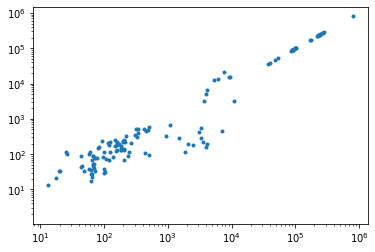

updated error_rates, RMSE: 1645.7716702973134
optimal_inaccurate


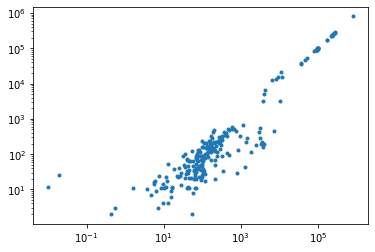

updated gen_counts, RMSE: 1650.741582252381


In [165]:
#famkey = random.choice(famkeys)
famsize = len(family_to_inds[famkey])
print(famkey, famsize)

fam_counts = np.sum(family_to_counts[famkey], axis=0)

errors = list(product(range(famsize), range(len(gens)), range(len(obs))))
print('errors', len(errors))

famgens = []
for famgen in product(range(len(gens)), repeat=famsize):
    is_mendelian = True
    for child_index in range(2, famsize):
        if (famgen[0], famgen[1], famgen[child_index]) not in mendelian_trios:
            is_mendelian = False
    if is_mendelian:
        famgens.append(famgen)
print('famgens', len(famgens))

famobss = [x for x in list(product(range(len(obs)), repeat=famsize)) if len([y for y in x if y != 0 and y != 3])>0]
print('famobs', len(famobss))

obs_counts = np.array([fam_counts[x] for x in famobss])
gen_counts = np.zeros((len(famgens),))

famgen_to_index = dict([(x, i) for i, x in enumerate(famgens)])
for i, famobs in enumerate(famobss):
    famgen = tuple([obs_to_gen[x] for x in famobs])
    if famgen in famgen_to_index:
        gen_counts[famgen_to_index[famgen]] += obs_counts[i]

error_to_pairs = create_error_graph(errors, famgens, famobss)

error_rates = estimate_error_rates(error_to_pairs, obs_counts, gen_counts, errors, famgens, famobss)
gen_counts = estimate_gen_counts(error_to_pairs, obs_counts, error_rates, errors, famgens, famobss)

#error_rates = estimate_error_rates(error_to_pairs, obs_counts, gen_counts, errors, famgens, famobss)
#gen_counts = estimate_gen_counts(error_to_pairs, obs_counts, error_rates, errors, famgens, famobss)

#error_rates = estimate_error_rates(error_to_pairs, obs_counts, gen_counts, errors, famgens, famobss)
#gen_counts = estimate_gen_counts(error_to_pairs, obs_counts, error_rates, errors, famgens, famobss)

#error_rates = estimate_error_rates(error_to_pairs, obs_counts, gen_counts, errors, famgens, famobss)
#gen_counts = estimate_gen_counts(error_to_pairs, obs_counts, error_rates, errors, famgens, famobss)


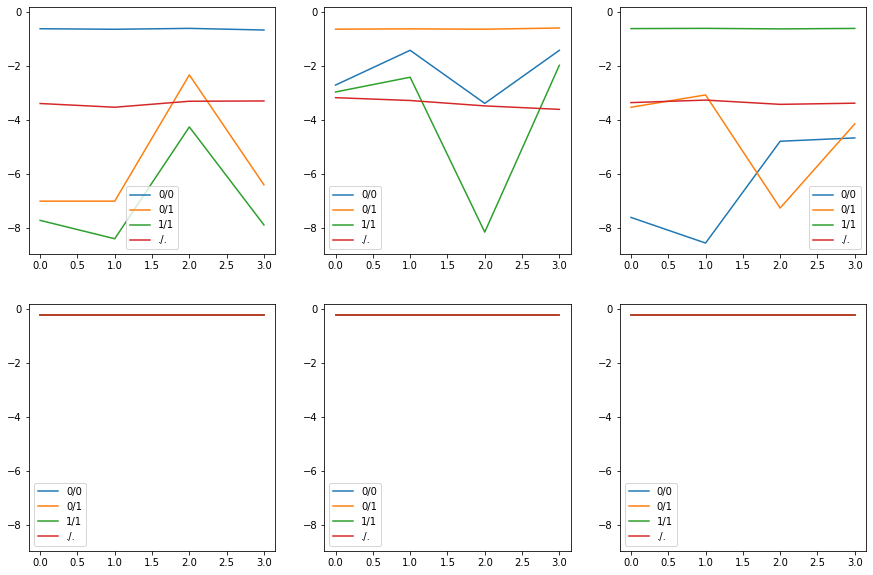

In [166]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

ax = plt.subplot(2, 3, 1)
for i, o in enumerate(obs):
    plt.plot(np.log10([rate for error, rate in zip(errors, error_rates) if error[1]==0 and error[2]==i]), label=o)
plt.legend()

plt.subplot(2, 3, 2, sharey=ax)
for i, o in enumerate(obs):
    plt.plot(np.log10([rate for error, rate in zip(errors, error_rates) if error[1]==1 and error[2]==i]), label=o)
plt.legend()
    
plt.subplot(2, 3, 3, sharey=ax)
for i, o in enumerate(obs):
    plt.plot(np.log10([rate for error, rate in zip(errors, error_rates) if error[1]==2 and error[2]==i]), label=o)
plt.legend()
    
plt.subplot(2, 3, 4, sharey=ax)
for i, o in enumerate(obs):
    plt.plot(np.log10([rate for error, rate in zip(errors, error_rates) if error[1]==3 and error[2]==i]), label=o)
plt.legend()

plt.subplot(2, 3, 5, sharey=ax)
for i, o in enumerate(obs):
    plt.plot(np.log10([rate for error, rate in zip(errors, error_rates) if error[1]==4 and error[2]==i]), label=o)
plt.legend()

plt.subplot(2, 3, 6, sharey=ax)
for i, o in enumerate(obs):
    plt.plot(np.log10([rate for error, rate in zip(errors, error_rates) if error[1]==5 and error[2]==i]), label=o)
plt.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

ax = plt.subplot(2, 3, 1)
for i, o in enumerate(obs):
    plt.plot(np.log10([rate for error, rate in zip(errors, error_rates) if error[1]==0 and error[2]==i]), label=o)
plt.legend()

plt.subplot(2, 3, 2, sharey=ax)
for i, o in enumerate(obs):
    plt.plot(np.log10([rate for error, rate in zip(errors, error_rates) if error[1]==1 and error[2]==i]), label=o)
plt.legend()
    
plt.subplot(2, 3, 3, sharey=ax)
for i, o in enumerate(obs):
    plt.plot(np.log10([rate for error, rate in zip(errors, error_rates) if error[1]==2 and error[2]==i]), label=o)
plt.legend()
    
plt.subplot(2, 3, 4, sharey=ax)
for i, o in enumerate(obs):
    plt.plot(np.log10([rate for error, rate in zip(errors, error_rates) if error[1]==3 and error[2]==i]), label=o)
plt.legend()

plt.subplot(2, 3, 5, sharey=ax)
for i, o in enumerate(obs):
    plt.plot(np.log10([rate for error, rate in zip(errors, error_rates) if error[1]==4 and error[2]==i]), label=o)
plt.legend()

plt.subplot(2, 3, 6, sharey=ax)
for i, o in enumerate(obs):
    plt.plot(np.log10([rate for error, rate in zip(errors, error_rates) if error[1]==5 and error[2]==i]), label=o)
plt.legend()

plt.show()